#   Práctica 3 - Reconstrucción de imágenes tomográficas: método directo

## Librerias - Programas

In [2]:
import cv2
import sys 
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os.path

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon
from skimage.transform.radon_transform import _get_fourier_filter


def read_pgm_file(file_name):
    """
    Reads a PGM file and returns the image as a grayscale image.

    Args:
        file_name (str): The name of the PGM file to be read.

    Returns:
        numpy.ndarray: The grayscale image read from the PGM file.
    """
    # data_dir = os.path.dirname(os.path.abspath(__file__))

    # # Test if file exists
    # file_path = os.path.join(data_dir, file_name)
    # assert os.path.isfile(file_path), 'file \'{0}\' does not exist'.format(file_path)
    img = cv2.imread(file_name,flags=cv2.IMREAD_GRAYSCALE)

    if img is not None:
        print('img.size: ', img.size)
    else:
        print('imread({0}) -> None'.format(file_name))

    return img

def show_img_hist(im,save=False, Name=""):
    
    vmin = np.amin(im)
    vmax = np.max(im)
    print("Intensity Min: {}   Max:{}".format(vmin,vmax))

    L = np.abs(int(vmax - vmin))
    print("Number of Levels: {}".format(L))
    fig = plt.figure(figsize=(16,6))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # imgplot = plt.imshow(im/np.amax(im))
    imgplot = ax1.imshow(im,cmap='gray', vmin=vmin, vmax=vmax)
    fig.colorbar(imgplot, ax=ax1)
    # cv2.imshow(infile,img)
    # cv2.waitKey(0)

    hist, bin_edges = np.histogram(im.ravel(),bins=L)
    ax2.bar(bin_edges[:-1], hist)
    plt.show()
    if save: 
        fig1 = plt.figure(figsize=(10,10))
        ax1 = fig1.add_subplot(111)
        imgplot = ax1.imshow(im,cmap='gray', vmin=vmin, vmax=vmax)
        fig1.colorbar(imgplot, ax=ax1)
        fig1.savefig(Name+"_img.png", bbox_inches='tight')
        fig2 = plt.figure(figsize=(10,10))
        ax2 = fig2.add_subplot(111)
        ax2.bar(bin_edges[:-1], hist)
        fig2.savefig(Name+"_hist.png", bbox_inches='tight')
    return

def save_img(im,Name=""):
    output_file_path = Name + '.pgm'
    imageio.imwrite(output_file_path, (im * 255).astype('uint8'))

def reescaleo(im, x, y):
    '''
    Resizes an image using the nearest neighbor interpolation method.
    '''
    H , W = im.shape
    scale_x = x/W
    scale_y = y/H

    new_H = int(H*scale_y)
    new_W = int(W*scale_x)

    new_img = np.zeros((new_H,new_W),dtype=np.uint8)

    X_ratio = W/new_W
    Y_ratio = H/new_H

    for i in range(new_H):
        for j in range(new_W):
            x = int(j*X_ratio)
            y = int(i*Y_ratio)

            x_int = int(x)
            y_int = int(y)
            x_frac = x - x_int
            y_frac = y - y_int

            if x_frac >= 0.5:   x_int += 1
            if y_frac >= 0.5:   y_int += 1

            new_img[i,j] = img[y_int,x_int]

    return new_img

##   1)

img.size:  25600
ORIGINAL--------------------------------
Intensity Min: 0   Max:255
Number of Levels: 255


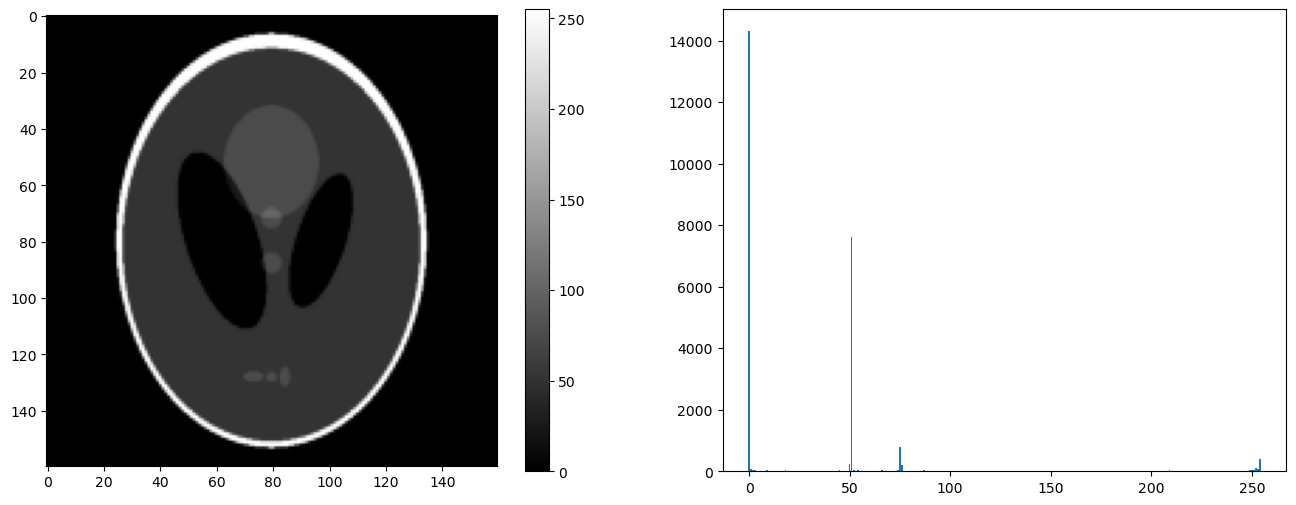

EQUALIZED--------------------------------
Intensity Min: 142   Max:255
Number of Levels: 113


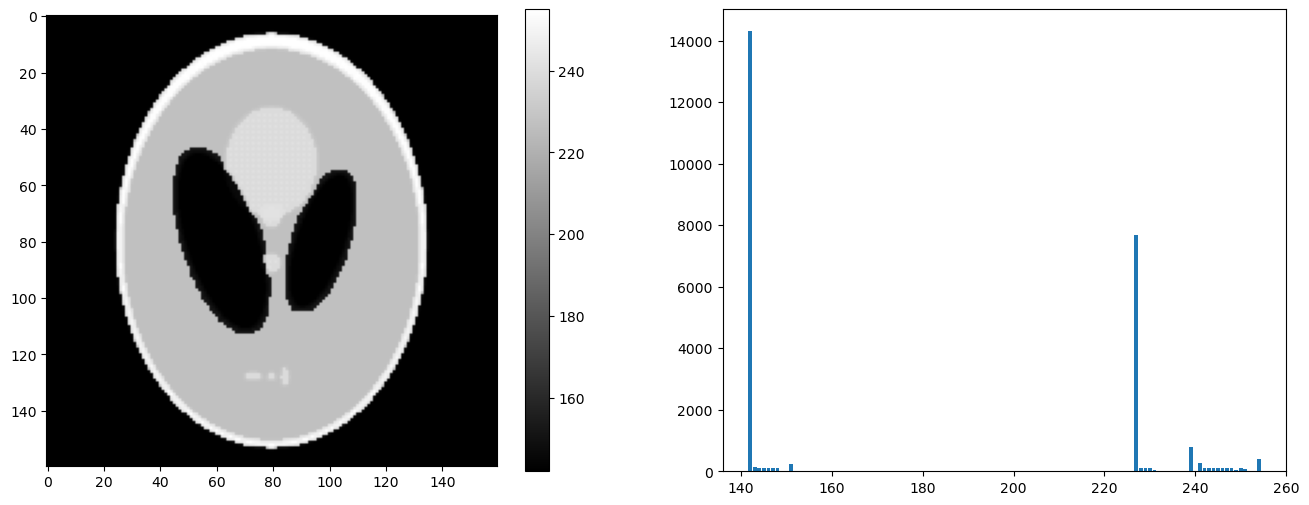

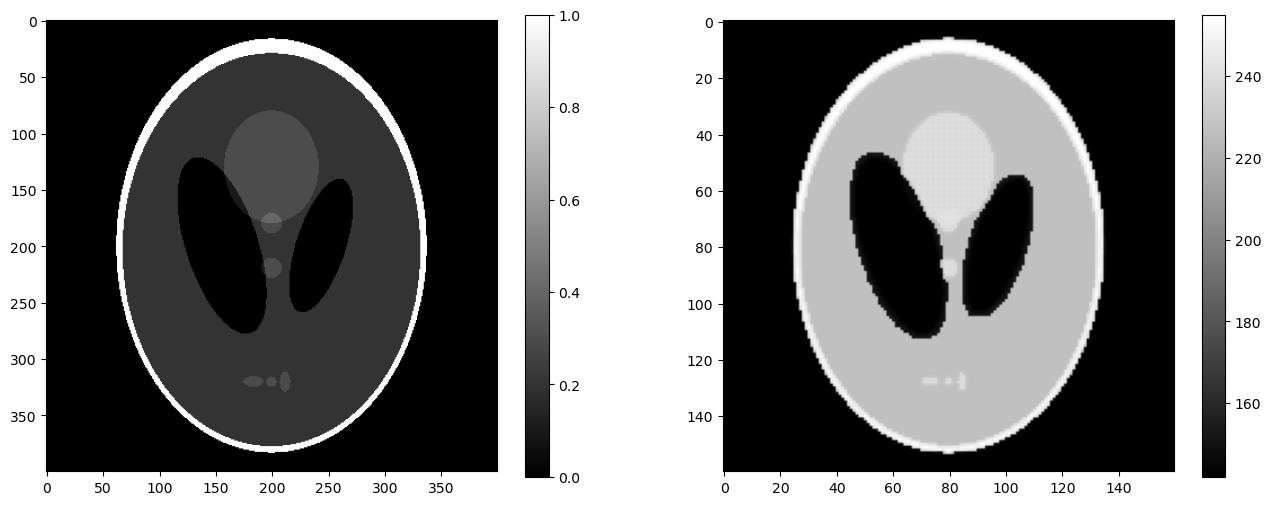

In [91]:
def equalization(im):
    hist, bin_edges = np.histogram(im.ravel(),bins=256) # histograma y bins
    cdf = hist.cumsum() #acumulado
    #   plt.plot(cdf)
    cdf = cdf / cdf[-1] #normalizo
    cdf = 255 * cdf #escalo

    for i in range(im.shape[0]): #recorro la imagen
        for j in range(im.shape[1]): 
            im[i,j] = cdf[im[i,j]] #reemplazo el valor de la imagen por el valor acumulado
    return

SheppLogan = shepp_logan_phantom()
image = rescale(SheppLogan, scale=0.4, mode='reflect')

# fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# ax1.imshow(image, cmap=plt.cm.Greys_r)

save_img(image,"shepp_logan_image")

# Read the image from the file
img_S_L = read_pgm_file("shepp_logan_image.pgm")
print("ORIGINAL--------------------------------")
show_img_hist(img_S_L)

print("EQUALIZED--------------------------------")
equalization(img_S_L)
show_img_hist(img_S_L)

fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
imgplot = ax1.imshow(SheppLogan,cmap='gray')
fig.colorbar(imgplot, ax=ax1)
imgplot = ax2.imshow(img_S_L,cmap='gray')
fig.colorbar(imgplot, ax=ax2)
plt.savefig("shepp_logan.png", bbox_inches='tight', dpi=300)



##  2)

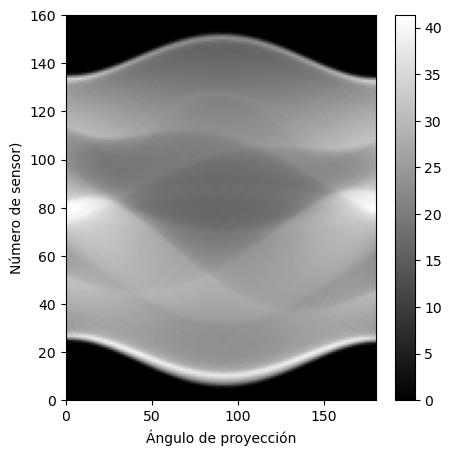

In [97]:
image = shepp_logan_phantom() #imagen de (400,400)
image = rescale(image, scale=0.4, mode='reflect') # imagen de (160,160)
tetha = np.linspace(0., 180., 120, endpoint=False)

sinogram = radon(image, theta=tetha)

fig = plt.figure(figsize=(5,5))
imagg = plt.imshow(sinogram, cmap='gray', extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
fig.colorbar(imagg)
plt.xlabel('Ángulo de proyección')
plt.ylabel('Número de sensor)')
plt.savefig("sinogram_2.png", bbox_inches='tight')

##  3)

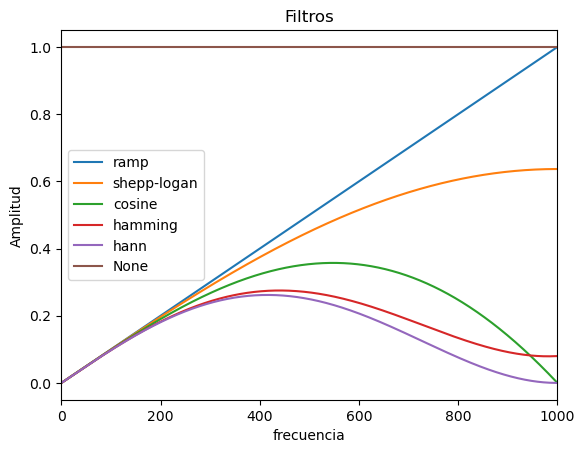

ramp


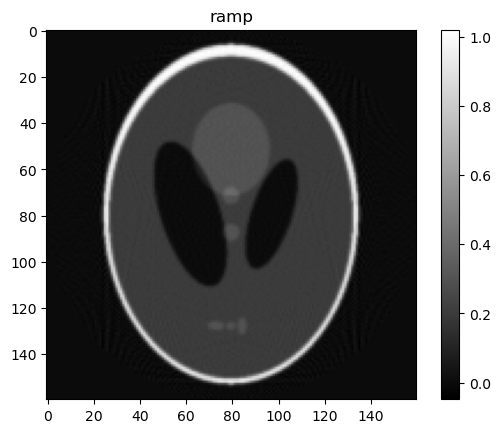

shepp-logan


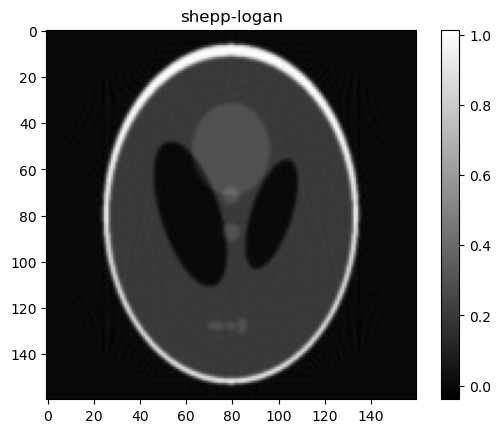

cosine


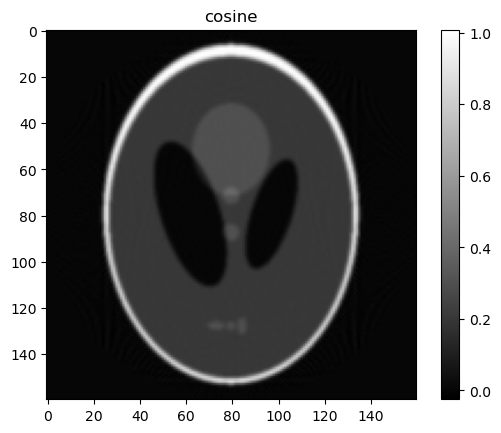

hamming


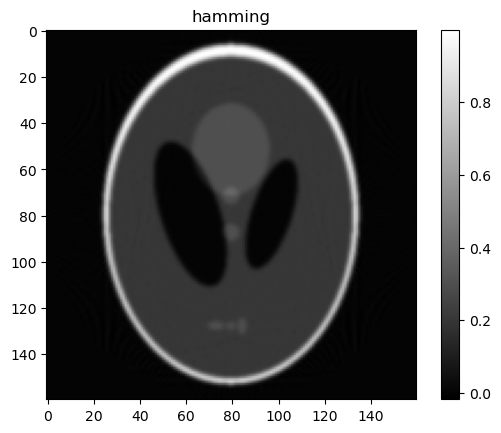

hann


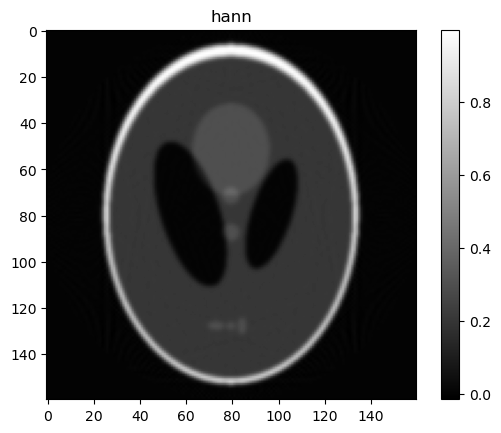

None


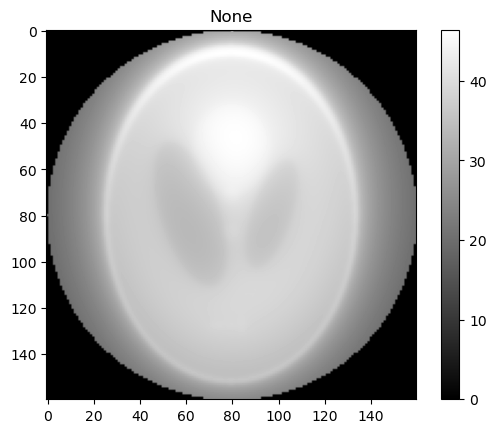

Filter: ramp  Error: 0.02863547073854106
Filter: shepp-logan  Error: 0.03301492437290378
Filter: cosine  Error: 0.04205599444597876
Filter: hamming  Error: 0.04964956574936044
Filter: hann  Error: 0.05158992925116725
Filter: None  Error: 30.93392092563303


In [108]:
#retroproyeccion
image = shepp_logan_phantom() #imagen de (400,400)
image = rescale(image, scale=0.4, mode='reflect') # imagen de (160,160)
tetha = np.linspace(0., 180., 120, endpoint=False)
sinogram = radon(image, theta=tetha)

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None]

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    if f is None:
        plt.plot(response, label='None')
    else: plt.plot(response, label=f)
plt.xlim([0, 1000])
plt.title('Filtros')
plt.ylabel('Amplitud')
plt.xlabel('frecuencia')
plt.legend()
plt.savefig("filters.png", bbox_inches='tight')
plt.show()

error = []
for ix, f in enumerate(filters):
    print (f)
    reconstruction_fbp = iradon(sinogram, theta=tetha, filter_name=f)
    img =plt.imshow(reconstruction_fbp, cmap='gray')
    plt.colorbar(img)
    plt.title(f)
    if f is None:
        plt.title('None')
        plt.savefig("reconstruction_fbp_None.png", bbox_inches='tight')
    else:   plt.savefig("reconstruction_fbp_{}.png".format(f), bbox_inches='tight')
    plt.show()
    error.append(np.sqrt(np.mean((reconstruction_fbp - image)**2)))

for i in range(len(filters)):   print('Filter: {}  Error: {}'.format(filters[i],error[i]))

## 4)

In [16]:
#creo imagen con cantidad de detectores
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

def imagen_gen(n_pixels, n_angles, filtro, print_bool=False): 

    image = shepp_logan_phantom() #imagen de (400,400)
    scale = n_pixels/400

    image = rescale(image, scale=scale, mode='reflect') # imagen de (n_pixels,n_pixels) pixeles == detectores
    angles = np.linspace(0., 180., n_angles, endpoint=False)

    sinogram = radon(image, theta=angles)
    reconstruction_fbp = iradon(sinogram, theta=angles, filter_name=filtro)

    
    error = np.sqrt(np.mean((reconstruction_fbp - image)**2))

    if print_bool:
        print('Filter: {}  Error: {}'.format(filtro,error))
        #plt.imshow(reconstruction_fbp, cmap='gray')

    return error

for i in range(len(filters)):
    imagen_gen(160, 120, filters[i] , False)

n_d = int(9)*2
n_a = int(10)*2
detectores = np.linspace(100, 1000, n_d, dtype=int)
angles = np.linspace(10, 200, 10,dtype=int)

#RAMP
ramp_err_d = []
ramp_err_a = []

for i in range(len(detectores)):
    ramp_err_d.append(imagen_gen(detectores[i], 120, filters[0], False))
for i in range(len(angles)):
    ramp_err_a.append(imagen_gen(160, angles[i], filters[0], False))

#Sheep_logan
S_L_error_d = []
S_L_error_a = []
for i in range(len(detectores)):
    S_L_error_d.append(imagen_gen(detectores[i], 120, filters[1], False))
for i in range(len(angles)):
    S_L_error_a.append(imagen_gen(160, angles[i], filters[1], False))

#COSINE
cosine_error_d = []
cosine_error_a = []
for i in range(len(detectores)):
    cosine_error_d.append(imagen_gen(detectores[i], 120, filters[2], False))
for i in range(len(angles)):
    cosine_error_a.append(imagen_gen(160, angles[i], filters[2], False))

#HAMMING
hamming_error_d = []
hamming_error_a = []
for i in range(len(detectores)):
    hamming_error_d.append(imagen_gen(detectores[i], 120, filters[3], False))
for i in range(len(angles)):
    hamming_error_a.append(imagen_gen(160, angles[i], filters[3], False))

#HANN
hann_error_d = []
hann_error_a = []
for i in range(len(detectores)):
    hann_error_d.append(imagen_gen(detectores[i], 120, filters[4], False))
for i in range(len(angles)):
    hann_error_a.append(imagen_gen(160, angles[i], filters[4], False))


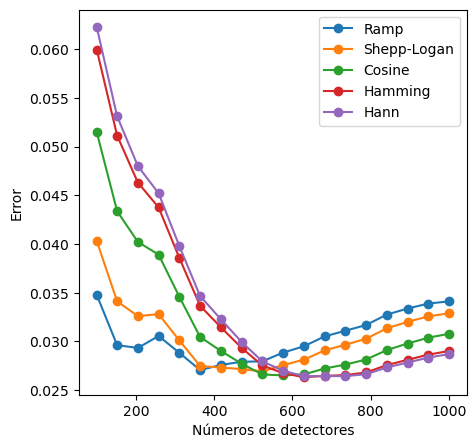

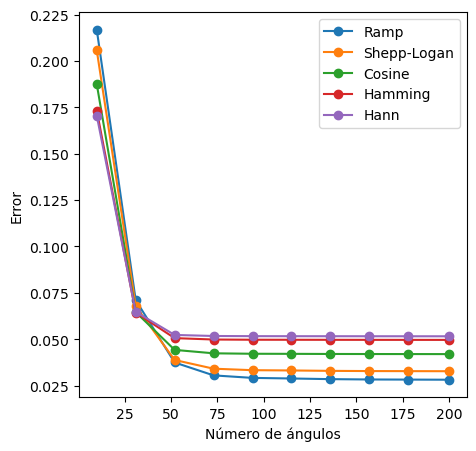

PARAMETROS OPTIMOS
RAMP: n_detec: 364, n_angles 200, -> error: 0.027059800793755005
SHEPP_LOGAN: n_detec: 523, n_angles 200, -> error: 0.02692450151267298
COSINE: n_detec: 576, n_angles 200, -> error: 0.026511044846844575
HAMMING: n_detec: 629, n_angles 200, -> error: 0.026323971794774127
HANN: n_detec: 629, n_angles 200, -> error: 0.026430562058347044


In [110]:
#plot
fig = plt.figure(figsize=(5,5))
plt.plot(detectores, ramp_err_d,'o-', label='Ramp')
plt.plot(detectores, S_L_error_d,'o-', label='Shepp-Logan')
plt.plot(detectores, cosine_error_d,'o-', label='Cosine')
plt.plot(detectores, hamming_error_d,'o-', label='Hamming')
plt.plot(detectores, hann_error_d,'o-', label='Hann')
plt.xlabel('Números de detectores')
plt.ylabel('Error')
plt.legend()
plt.savefig("Error_vs_Numero_de_detectores.png", bbox_inches='tight', dpi=300)
plt.show()

fig = plt.figure(figsize=(5,5))
plt.plot(angles, ramp_err_a,'o-', label='Ramp')
plt.plot(angles, S_L_error_a,'o-', label='Shepp-Logan')
plt.plot(angles, cosine_error_a,'o-', label='Cosine')
plt.plot(angles, hamming_error_a,'o-', label='Hamming')
plt.plot(angles, hann_error_a,'o-', label='Hann')
plt.xlabel('Número de ángulos')
plt.ylabel('Error')
plt.legend()
plt.savefig("Error_vs_Numero_de_angulos.png", bbox_inches='tight', dpi=300)
plt.show()

print("PARAMETROS OPTIMOS")
print("RAMP: n_detec: {}, n_angles {}, -> error: {}".format(detectores[np.argmin(ramp_err_d)], angles[np.argmin(ramp_err_a)], min(ramp_err_d)))
print("SHEPP_LOGAN: n_detec: {}, n_angles {}, -> error: {}".format(detectores[np.argmin(S_L_error_d)], angles[np.argmin(S_L_error_a)], min(S_L_error_d)))
print("COSINE: n_detec: {}, n_angles {}, -> error: {}".format(detectores[np.argmin(cosine_error_d)], angles[np.argmin(cosine_error_a)], min(cosine_error_d)))
print("HAMMING: n_detec: {}, n_angles {}, -> error: {}".format(detectores[np.argmin(hamming_error_d)], angles[np.argmin(hamming_error_a)], min(hamming_error_d)))
print("HANN: n_detec: {}, n_angles {}, -> error: {}".format(detectores[np.argmin(hann_error_d)], angles[np.argmin(hann_error_a)], min(hann_error_d)))



## 5)

RAMP--------------------------------
Filter: ramp  Error: 0.2534901282767332
Shepp-Logan--------------------------------
Filter: shepp-logan  Error: 0.205018462744385
COSINE--------------------------------
Filter: cosine  Error: 0.13260123383499703
HAMMING--------------------------------
Filter: hamming  Error: 0.10541407788266731
HANN--------------------------------
Filter: hann  Error: 0.09809269927603301


0.09809269927603301

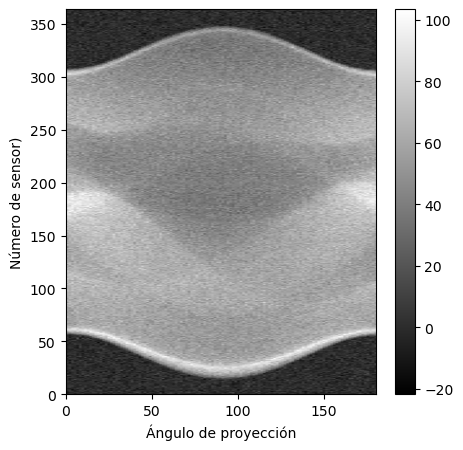

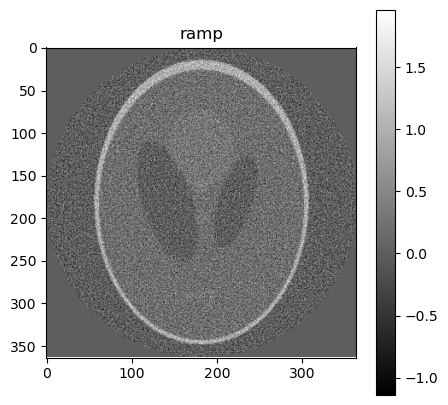

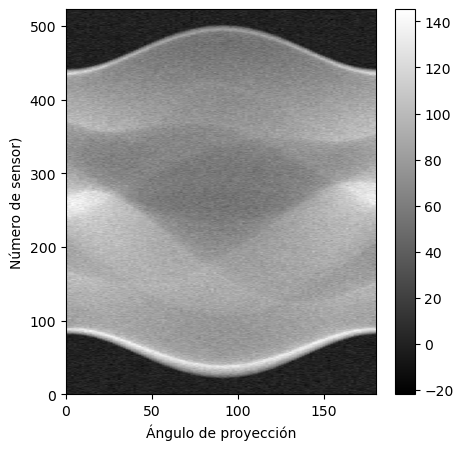

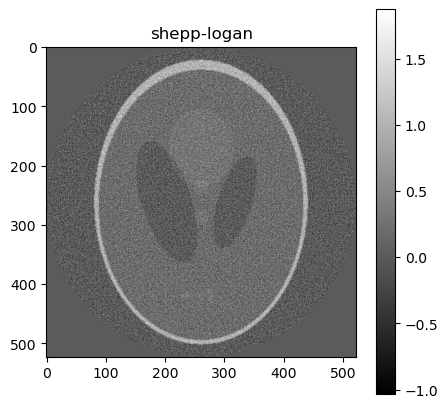

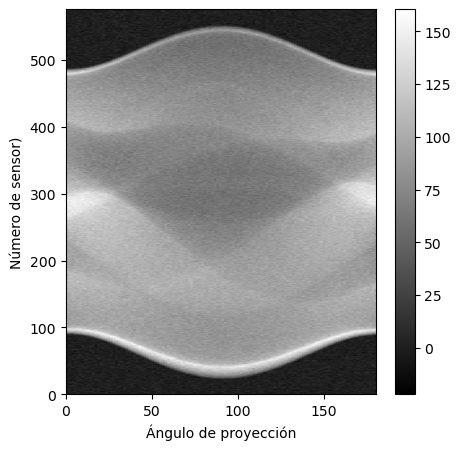

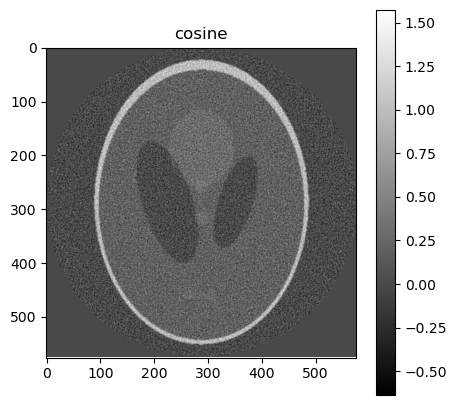

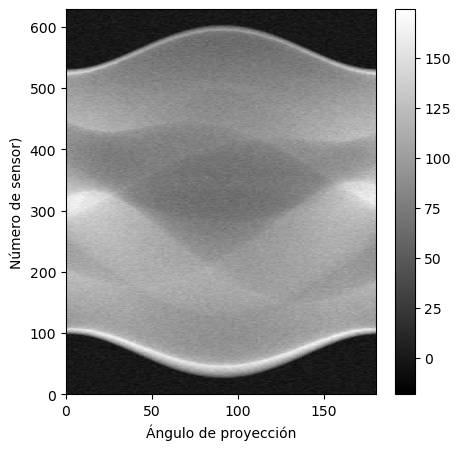

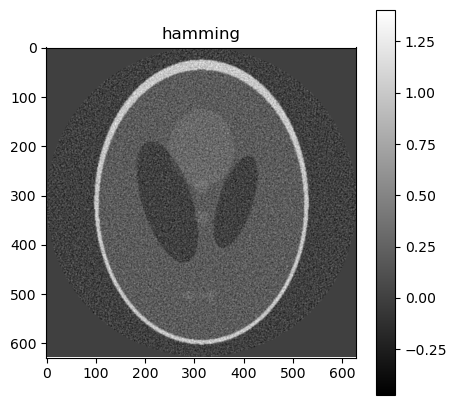

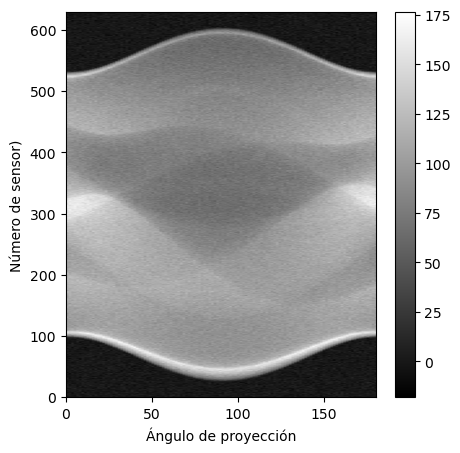

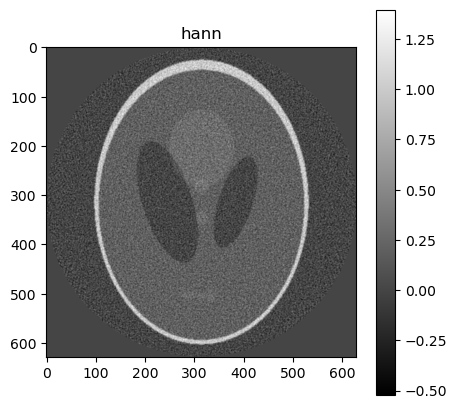

In [117]:
def gaussian_noise(img,mean,std, scale):
    #plt.imshow(img, cmap='gray')
    #plt.show()
    noise = np.random.normal(mean, std, img.shape) * scale
    img = img + noise
    #plt.imshow(img, cmap='gray')
    #plt.show()
    return img

def imagen_gen_noise(n_pixels, n_angles, filtro, print_bool=True): 

    image = shepp_logan_phantom() #imagen de (400,400)
    scale = n_pixels/400
    
    image = rescale(image, scale=scale, mode='reflect') # imagen de (n_pixels,n_pixels) pixeles == detectores
    angles = np.linspace(0., 180., n_angles, endpoint=False)

    sinogram = radon(image, theta=angles)
    sinogram_noise = gaussian_noise(sinogram,0,1,5)

    fig = plt.figure(figsize=(5,5))
    imgplot = plt.imshow(sinogram_noise, cmap='gray', extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    fig.colorbar(imgplot)
    plt.xlabel('Ángulo de proyección')
    plt.ylabel('Número de sensor)')
    plt.savefig("sinogram_noise_2.png", bbox_inches='tight')
    

    reconstruction_fbp = iradon(sinogram, theta=angles, filter_name=filtro)
    reconstruction_fbp_noise = iradon(sinogram_noise, theta=angles, filter_name=filtro)

    error = np.sqrt(np.mean((reconstruction_fbp_noise - image)**2))
    if print_bool:
        print('Filter: {}  Error: {}'.format(filtro,error))
        fig = plt.figure(figsize=(5,5))
        ax2 = plt.subplot(1, 1, 1)
        imgplot = ax2.imshow(reconstruction_fbp_noise,cmap='gray')
        fig.colorbar(imgplot, ax=ax2)
        plt.title(filtro)
        plt.savefig("reconstruction_fbp_noise_{}.png".format(filtro), bbox_inches='tight')

    return error

print("RAMP--------------------------------")
imagen_gen_noise(364, 120, filters[0], True)
print("Shepp-Logan--------------------------------")
imagen_gen_noise(523, 120, filters[1], True)
print("COSINE--------------------------------")
imagen_gen_noise(576, 120, filters[2], True)
print("HAMMING--------------------------------")
imagen_gen_noise(629, 120, filters[3], True)
print("HANN--------------------------------")
imagen_gen_noise(629, 120, filters[4], True) 

## 6)

Filter: None, N_Angles: 8, Error: 20.210240696362224
Filter: ramp, N_Angles: 8, Error: 21.103681068189747
Filter: None, N_Angles: 16, Error: 20.204673390119865
Filter: ramp, N_Angles: 16, Error: 21.104492984202427
Filter: None, N_Angles: 32, Error: 20.20483979868042
Filter: ramp, N_Angles: 32, Error: 21.104606474412602
Filter: None, N_Angles: 64, Error: 20.20485848118843
Filter: ramp, N_Angles: 64, Error: 21.104564867361177


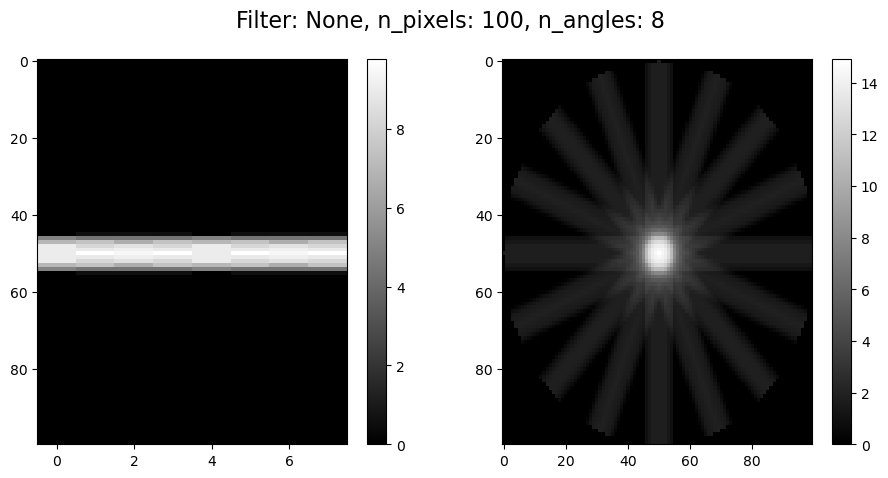

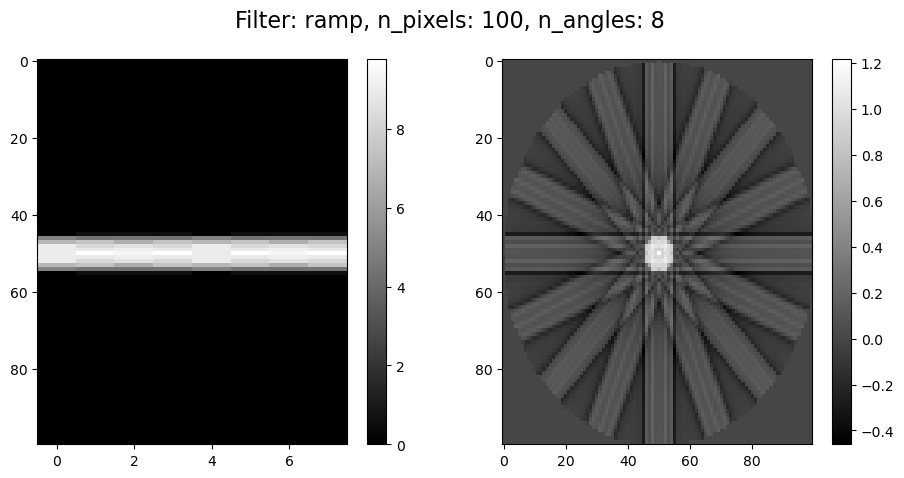

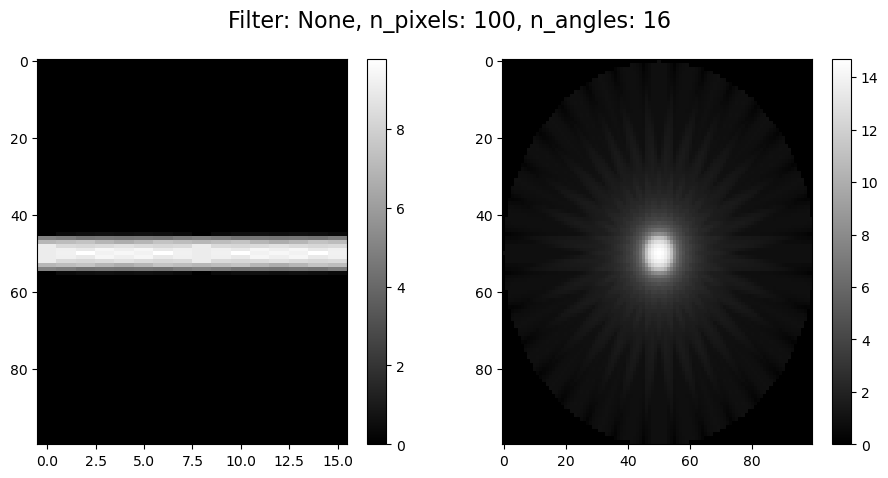

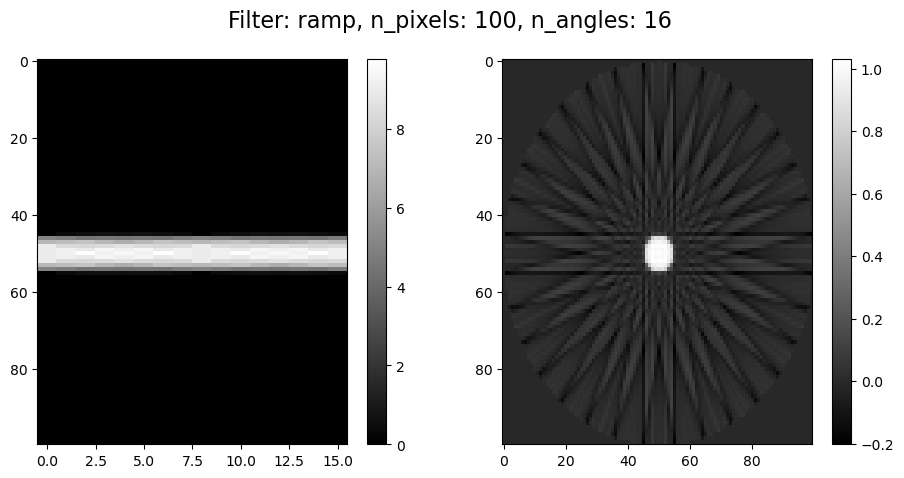

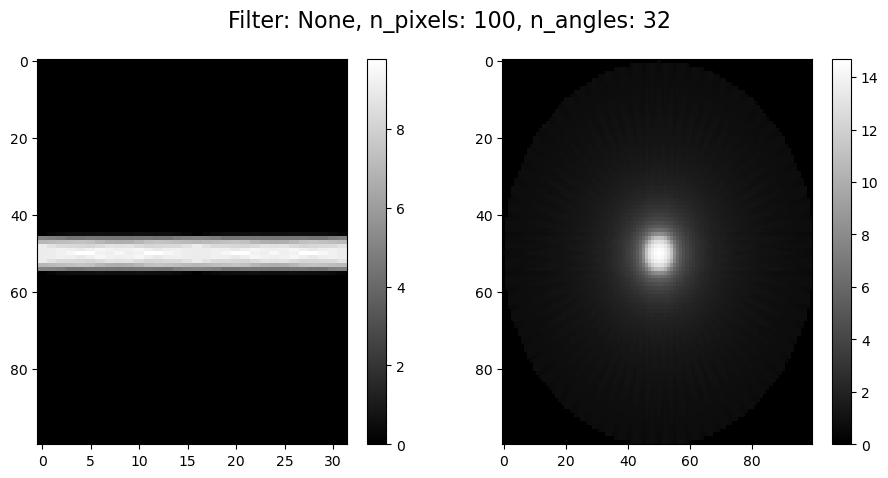

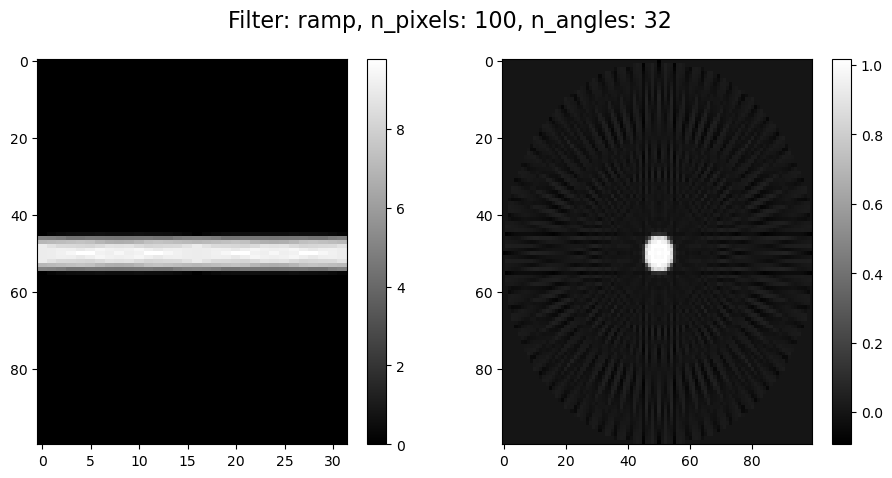

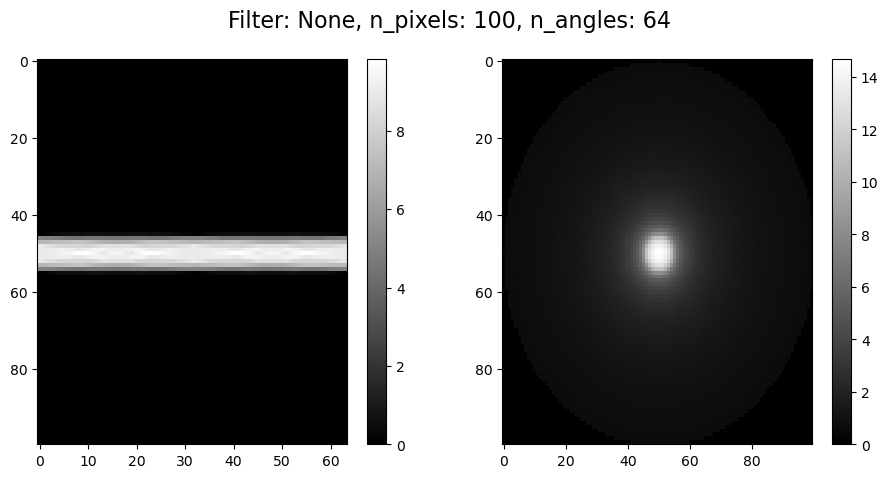

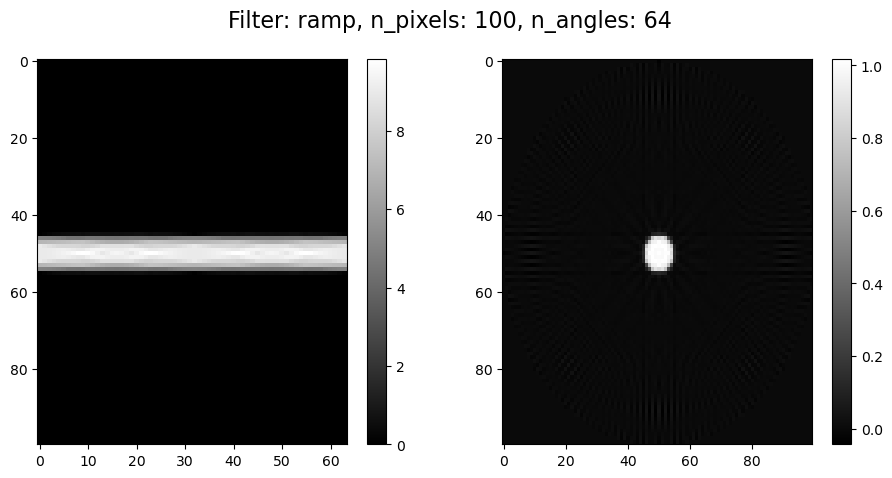

In [130]:
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
def im_circulo(l,radio, x, y):
    im = np.zeros((l,l),dtype=np.uint8)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (i-x)**2 + (j-y)**2 < radio**2:
                im[i,j] = 255
    return im

def imagen_gen_circle(radio, n_pixels, n_angles, filtro, print_bool=True):

    if print_bool:
        fig = plt.figure(figsize=(11,5))
        fig.suptitle('Filter: {}, n_pixels: {}, n_angles: {}'.format(filtro,n_pixels,n_angles), fontsize=16)
        #ax1 = plt.subplot(1, 3, 1)
        ax2 = plt.subplot(1, 2, 1)
        ax3 = plt.subplot(1, 2, 2)

    if (n_pixels/2)%1 != 0:
        print("n_pixels tiene que ser par")
        return
    
    image = im_circulo(n_pixels,radio, n_pixels/2, n_pixels/2)
    #if print_bool: 
        #imgplot = ax1.imshow(image,cmap='gray',aspect='auto')
        #fig.colorbar(imgplot, ax=ax1)

    angles = np.linspace(0., 180., n_angles, endpoint=False)

    sinogram = radon(image, theta=angles)
    if print_bool: 
        imgplot = ax2.imshow(sinogram, cmap='gray',aspect='auto')
        fig.colorbar(imgplot, ax=ax2)
    reconstruction_fbp = iradon(sinogram, theta=angles, filter_name=filtro)
    if print_bool: 
        imgplot = ax3.imshow(reconstruction_fbp,cmap='gray',aspect='auto')
        fig.colorbar(imgplot, ax=ax3)

    error = np.sqrt(np.mean((reconstruction_fbp - image)**2))
    if print_bool: print('Filter: {}, N_Angles: {}, Error: {}'.format(filtro,n_angles,error))

    fig.savefig("reconstruction_fbp_circle_{}_{}.png".format(filtro,n_angles), bbox_inches='tight')
    return error

pr = [8,16,32,64]
for j in pr:
    imagen_gen_circle(5, 100, j, None, True)
    imagen_gen_circle(5, 100, j, filters[0], True)



## 7)

(160, 120)


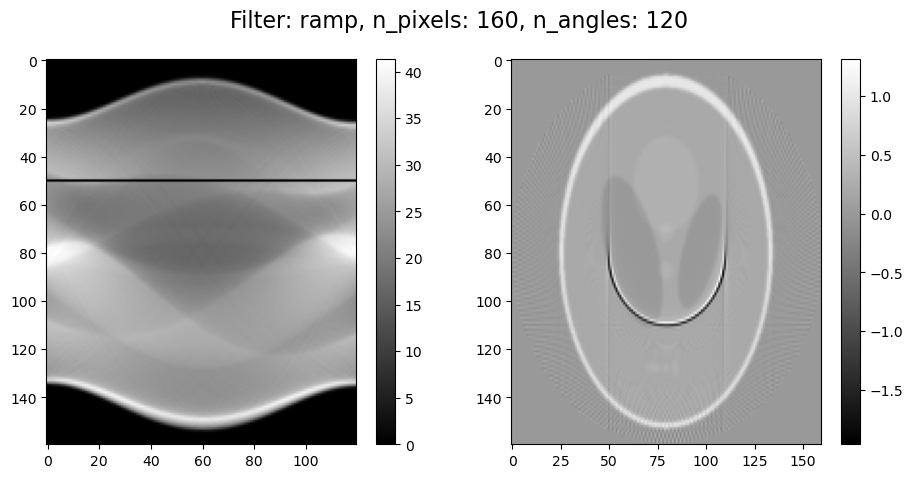

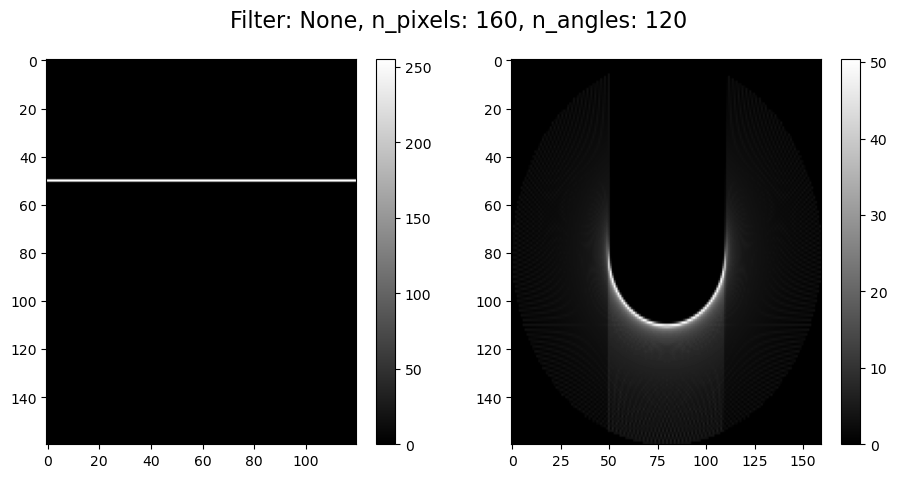

In [139]:
def imagen_gen_break(n_pixels, n_angles, filtro, print_bool=True):
    
    if print_bool:
        fig = plt.figure(figsize=(11,5))
        fig.suptitle('Filter: {}, n_pixels: {}, n_angles: {}'.format(filtro,n_pixels,n_angles), fontsize=16)
        ax2 = plt.subplot(1, 2, 1)
        ax3 = plt.subplot(1, 2, 2)

    
    image = shepp_logan_phantom() #imagen de (400,400)
    scale = n_pixels/400

    image = rescale(image, scale=scale, mode='reflect') # imagen de (n_pixels,n_pixels) pixeles == detectores
    angles = np.linspace(0., 180., n_angles, endpoint=False)

    sinogram = radon(image, theta=angles)
    print(sinogram.shape)
    #if print_bool:
    #    imgplot = ax1.imshow(sinogram, cmap='gray', extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    #    fig.colorbar(imgplot, ax=ax1)
    
    for i in range(sinogram.shape[1]):
        sinogram[50,i] = 0
    if print_bool:
        imgplot = ax2.imshow(sinogram, cmap='gray', aspect='auto')
        fig.colorbar(imgplot, ax=ax2)

    reconstruction_fbp = iradon(sinogram, theta=angles, filter_name=filtro)
    
    if print_bool:
        imgplot = ax3.imshow(reconstruction_fbp,cmap='gray',aspect='auto')
        fig.colorbar(imgplot, ax=ax3)
    fig.savefig("reconstruction_fbp_break_{}.png".format(filtro),bbox_inches='tight')
    plt.show()

    return 

def im_line(l,x,y):
    im = np.zeros((x,y),dtype=np.uint8)
    for i in range(im.shape[1]):
        im[l,i] = 255
    return im


def imagen_gen_line(n_pixels, n_angles, filtro, print_bool=True): 
    fig = plt.figure(figsize=(11,5))
    fig.suptitle('Filter: {}, n_pixels: {}, n_angles: {}'.format(filtro,n_pixels,n_angles), fontsize=16)
    ax2 = plt.subplot(1, 2, 1)
    ax3 = plt.subplot(1, 2, 2)

    angles = np.linspace(0., 180., n_angles, endpoint=False)

    sinogram = im_line(50,n_pixels,n_angles)

    imgplot = ax2.imshow(sinogram, cmap='gray', aspect='auto')
    fig.colorbar(imgplot, ax=ax2)

    reconstruction_fbp = iradon(sinogram, theta=angles, filter_name=filtro)
    imgplot = ax3.imshow(reconstruction_fbp,cmap='gray',aspect='auto')
    fig.colorbar(imgplot, ax=ax3)
    fig.savefig("reconstruction_fbp_line_{}.png".format(filtro),bbox_inches='tight')
    return 

imagen_gen_break(160, 120, filters[0] , True)
imagen_gen_line(160, 120, None , True)





